## Initialization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
# Load label csv file
labels = pd.read_csv('/datasets/faces/labels.csv')

## EDA

In [3]:
labels.shape

(7591, 2)

In [4]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

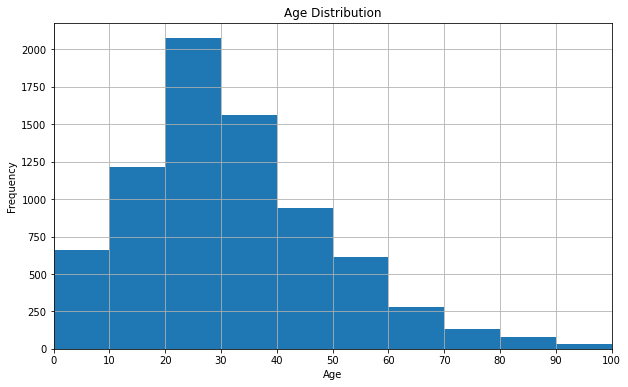

In [5]:
# Set the size of the figure
plt.figure(figsize=(10, 6))

# Plot histogram with specific bin size
labels['real_age'].hist(bins=range(0, max(labels['real_age']) + 5, 10))

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Set xticks to 10-year intervals
plt.xticks(np.arange(0, 101, 10))

# Set axes limits
plt.xlim([0, max(labels['real_age'])])
plt.ylim([0, plt.gca().get_ylim()[1]])

plt.show()

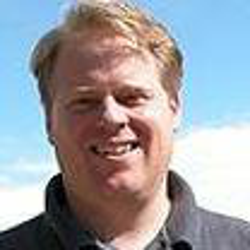

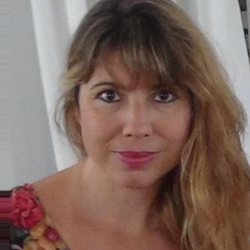

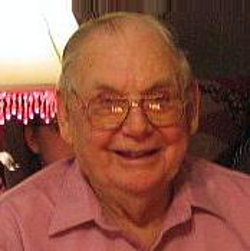

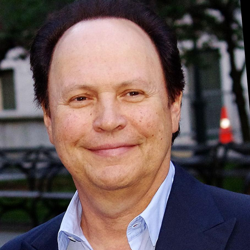

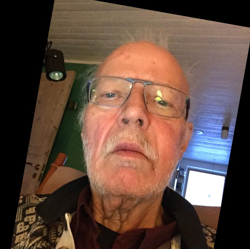

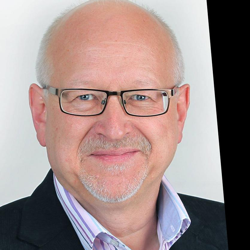

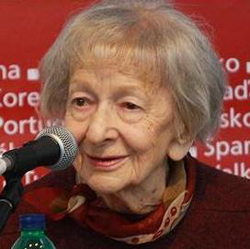

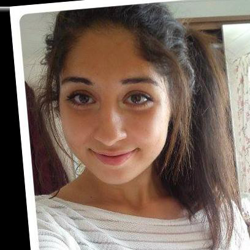

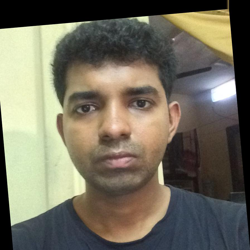

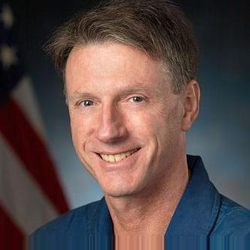

In [6]:
labels_no_duplicates = labels.drop_duplicates(subset='real_age')
age_samples_10_files = labels_no_duplicates.sample(10)['file_name']

for row in age_samples_10_files:
    # Open an image file
    img = Image.open('/datasets/faces/final_files/' + row)

    # Calculate height relative to new width, preserving aspect ratio
    new_width = 250
    new_height = int(new_width * (img.height / img.width))

    # Resize the image
    img_resized = img.resize((new_width, new_height))

    # Display the resized image
    img_resized.show()

### Findings

- Dataset contains photos for age range 1 to 100
- Age distribution has positive skew, with 50% of dataset younger than 29. The largest group is 20 to 30, followed by 30 to 40, and 10 to 20. 
- Image sizes and sharpness are not uniform across dataset

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [7]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [8]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    horizontal_flip=True,
    rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels, 
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

In [9]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
    validation_split=0.25,
    horizontal_flip=True,
    rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/', 
        x_col='file_name',
        y_col='real_age',        
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

In [10]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(
    input_shape=input_shape, weights='imagenet', include_top=False
)
    model = Sequential()
    
    optimizer = Adam(lr=0.0001)
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(
        optimizer=optimizer,
        loss='mae',
        metrics=['mae'],
    )

    return model

In [11]:
def train_model(model, train_data, test_data, batch_size=None, epochs=8,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
    )

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [12]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Train for 356 steps, validate for 119 steps  
Epoch 1/8  
2023-07-22 20:09:43.614208: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10  
2023-07-22 20:09:44.579862: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7  
356/356 - 65s - loss: 11.2299 - mae: 11.2304 - val_loss: 15.5475 - val_mae: 15.5330  
Epoch 2/8  
356/356 - 36s - loss: 7.7865 - mae: 7.7864 - val_loss: 9.3853 - val_mae: 9.3865  
Epoch 3/8  
356/356 - 36s - loss: 6.6785 - mae: 6.6784 - val_loss: 8.2378 - val_mae: 8.2423  
Epoch 4/8  
356/356 - 36s - loss: 6.0424 - mae: 6.0418 - val_loss: 8.3341 - val_mae: 8.3205  
Epoch 5/8  
356/356 - 36s - loss: 5.4668 - mae: 5.4671 - val_loss: 6.8353 - val_mae: 6.8412  
Epoch 6/8  
356/356 - 36s - loss: 4.9416 - mae: 4.9412 - val_loss: 7.0509 - val_mae: 7.0530  
Epoch 7/8  
356/356 - 36s - loss: 4.5493 - mae: 4.5497 - val_loss: 6.9681 - val_mae: 6.9642  
Epoch 8/8  
356/356 - 36s - loss: 4.2306 - mae: 4.2308 - val_loss: 6.3807 - val_mae: 6.3824  

119/119 - 9s - loss: 6.3373 - mae: 6.3365  
Test MAE: 6.3365

### Model Validation for 21 and less dataset

Let's see how the model performs on a validation set for ages 21 and less

In [13]:
labels_1_to_21 = labels[labels['real_age'] <= 21]
labels_1_to_21

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
4,000004.jpg,17
10,000010.jpg,17
12,000012.jpg,2
...,...,...
7580,007602.jpg,1
7583,007605.jpg,5
7585,007607.jpg,10
7586,007608.jpg,14


In [14]:
# Modified load_test() function to use labels_1_to_21

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    labels_1_to_21 = labels[labels['real_age'] <= 21]
    test_datagen = ImageDataGenerator(
    horizontal_flip=True,
    rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels_1_to_21,
        directory=path + 'final_files/', 
        x_col='file_name',
        y_col='real_age',        
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

#### Output from GPU Platform

2023-07-22 20:57:49.454716: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6  
2023-07-22 20:57:49.456372: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6  
Using TensorFlow backend.  
Found 5694 validated image filenames.  
Found 549 validated image filenames.  

Train for 356 steps, validate for 35 steps  
Epoch 1/8  
2023-07-22 20:58:11.681613: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10  
2023-07-22 20:58:13.280214: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7  
356/356 - 58s - loss: 10.9758 - mae: 10.9769 - val_loss: 8.0345 - val_mae: 8.0949  
Epoch 2/8  
356/356 - 29s - loss: 7.7473 - mae: 7.7475 - val_loss: 6.8322 - val_mae: 6.8524 
Epoch 3/8  
356/356 - 29s - loss: 6.7751 - mae: 6.7755 - val_loss: 6.5687 - val_mae: 6.6345  
Epoch 4/8  
356/356 - 29s - loss: 5.9734 - mae: 5.9739 - val_loss: 4.4089 - val_mae: 4.4291  
Epoch 5/8  
356/356 - 30s - loss: 5.3797 - mae: 5.3803 - val_loss: 4.4534 - val_mae: 4.5148  
Epoch 6/8  
356/356 - 29s - loss: 4.8334 - mae: 4.8334 - val_loss: 3.9344 - val_mae: 3.9747  
Epoch 7/8  
356/356 - 29s - loss: 4.5645 - mae: 4.5647 - val_loss: 5.1625 - val_mae: 5.2328  
Epoch 8/8  
356/356 - 30s - loss: 4.1728 - mae: 4.1729 - val_loss: 5.3297 - val_mae: 5.3917  

35/35 - 2s - loss: 5.2800 - mae: 5.3501  
Test MAE: 5.3501  

## Conclusions

- Trained ResNet50 achieves MAE of 6.3 in 8 epochs, which is acceptable per customer requirement, and indicates that on average the model predicted age is within +/- 6.3 of actual age.
- Trained model achieves lower MAE of 5.35 with validation dataset from 21 or younger, which aligns with expectations since the dataset was skewed and 50% of it is 29 and younger.
- Customer is recommended to do manual age verification along with the ResNet50 trained model in place, to compare the predicted value to actual and be able to get an error distribution. From that, a prediction confidence interval can be calculated, and an appropriate threshold can be set for automatic age verification for alcohol purchasers. 
- Age predictions can potentially be used to gain insights into customer preferences by combining products purchased with age predictions

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training